In [1]:
# !nvidia-smi

In [ ]:
!pip install ultralytics albumentations==2.0.5 optuna==4.2.1 huggingface-hub==0.30.2 torchmetrics==1.7.1 lmdb==1.6.2 msgpack==1.1.0 opencv-python==4.11.0.86 torch==2.6.0 torchvision==0.21.0 numpy==2.2.4 tqdm==4.67.1 --upgrade --upgrade-strategy eager

In [ ]:
!pip install --upgrade pip
!pip install  
!git clone https://github.com/sathishkumar67/ADIS.git
!mv /kaggle/working/ADIS/* /kaggle/working/

# necessary imports
import os
from huggingface_hub import hf_hub_download
from utils import unzip_file

REPO_ID = "pt-sk/ADIS" 
DATASET_NAME = "balanced_dataset"
REPO_TYPE = "dataset"
FILENAME_IN_REPO = f"{DATASET_NAME}.zip"
LOCAL_DIR = os.getcwd()
DATASET_PATH = f"{LOCAL_DIR}/{FILENAME_IN_REPO}"
DATASET_FOLDER_PATH = f"{LOCAL_DIR}/{DATASET_NAME}"
NUM_CLASSES = 10                                               
CLASSES = ['Cat', 'Cattle', 'Chicken', 'Deer', 'Dog', 'Squirrel', 'Eagle', 'Goat', 'Rodents', 'Snake'] 
BACKGROUND_CLASS_ID = 0
MODEL_NUM_CLASSES = NUM_CLASSES + 1     # 1 for background class

# download the dataset and unzip it
hf_hub_download(repo_id=REPO_ID, filename=FILENAME_IN_REPO, repo_type=REPO_TYPE, local_dir=LOCAL_DIR)
unzip_file(DATASET_PATH, LOCAL_DIR)

# remove dataset.zip
os.remove(DATASET_PATH)

# number of cores
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.0/973.0 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 158.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 82.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 35.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 28.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 62.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 64.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 61.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB

ImportError: cannot import name 'fastCopyAndTranspose' from 'numpy.core._multiarray_umath' (/usr/local/lib/python3.11/dist-packages/numpy/core/_multiarray_umath.py)

In [ ]:
from typing import Tuple
from tqdm import tqdm
import msgpack
import os
import cv2
import lmdb
import numpy as np
import shutil
from functools import partial
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from torchvision.models.detection import _utils as det_utils
from torchmetrics.detection import MeanAveragePrecision
from typing import List, Tuple, Dict, Any # Import necessary 

In [ ]:
class SSDLITEOBJDET_DATASET(Dataset):
    def __init__(self, root_dir: str, split: str, num_classes: int, img_size: int=320, dtype: torch.dtype=torch.float8_e4m3fn, mode: str="train") -> None:
        super().__init__()
        self.root_dir, self.split, self.img_size, self.num_classes = root_dir, split.lower(), img_size, num_classes
        self.current_dir = os.path.join(self.root_dir, self.split)
        self.dtype, self.mode = dtype, mode.lower()
        
        # check if model is train or eval
        if self.mode not in ["train", "eval"]:
            raise ValueError(f"Invalid mode: {self.mode}. Expected 'train' or 'eval'.")
        
        # set interpolation method for resizing
        self.interpolation = cv2.INTER_LANCZOS4 if self.mode == "train" else cv2.INTER_LINEAR

        # Validate current directory
        if not os.path.exists(self.current_dir):
            raise FileNotFoundError(f"{self.current_dir} does not exist.")
        elif not os.path.isdir(self.current_dir):
            raise NotADirectoryError(f"{self.current_dir} is not a directory.")
        
        # check if the split directory is empty
        if len(os.listdir(self.current_dir)) == 0:
            raise ValueError(f"The directory {self.current_dir} is empty.")
        
        # get image and label files
        self.image_files = sorted(
            [os.path.join(self.current_dir, f) for f in os.listdir(self.current_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))],
            key=lambda x: os.path.splitext(x)[0]
        )
        self.label_files = [os.path.join(self.current_dir, os.path.splitext(f)[0] + '.txt') for f in self.image_files]

        # Validate existence for ALL label files
        for img_file, lbl_file in zip(self.image_files, self.label_files):
            if not os.path.exists(lbl_file):
                raise FileNotFoundError(f"Label file missing for {img_file}")

    def __len__(self) -> int:
        # print the no of items in the dataset
        print(f"Number of items in the dataset: {len(self.image_files)}")
        return len(self.image_files)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, dict]:
        img_path, label_path = self.image_files[idx], self.label_files[idx]

        # Read image and convert to RGB format
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        orig_height, orig_width, _ = image.shape
        # tensor with uint8 datatype 
        image = cv2.resize(image, (self.img_size, self.img_size), interpolation=self.interpolation)
        
        # Read label file and parse the bounding boxes and labels
        data = np.loadtxt(label_path, dtype=np.float32, delimiter=' ', ndmin=2)
        
        if data.size == 0:
            return image, {
                'boxes': np.array([[0.0, 0.0, 1.0, 1.0]], dtype=np.float32),
                'labels': np.array(0, dtype=np.uint8)
            }
        else:
            # Convert normalized box coordinates into absolute coordinates, where orig_width and orig_height are your original dimensions.
            cx, cy, w, h = data[:, 1], data[:, 2], data[:, 3], data[:, 4]
            xmin = np.maximum(0, (cx - w/2) * orig_width)
            ymin = np.maximum(0, (cy - h/2) * orig_height)
            xmax = np.minimum(orig_width, (cx + w/2) * orig_width)
            ymax = np.minimum(orig_height, (cy + h/2) * orig_height)

            # Filter degenerate boxes (width or height less than 1)
            valid_mask = ((xmax - xmin) >= 1) & ((ymax - ymin) >= 1)
            valid_boxes = np.stack([xmin[valid_mask], ymin[valid_mask],
                                    xmax[valid_mask], ymax[valid_mask]], axis=1)

            # Adjust class IDs (cid from first column)
            valid_labels = data[valid_mask, 0].astype(np.uint8) 
            np.add(valid_labels, 1, out=valid_labels)  # Increment class IDs by 1 for background class

            # scale boxes to new image size
            scale_factors = np.array([self.img_size / orig_width, self.img_size / orig_height,
                                    self.img_size / orig_width, self.img_size / orig_height], dtype=valid_boxes.dtype)
            np.multiply(valid_boxes, scale_factors, out=valid_boxes)

            # Validate class IDs
            if valid_labels and np.all((valid_labels < 0) & (valid_labels > self.num_classes)):
                raise ValueError(f"Invalid class ID in {label_path}")
            
            target = {
                'boxes': valid_boxes, #self.normalize(boxes) if self.mode == "train" else boxes,
                'labels': valid_labels
            }
            return image, target
        
    def normalize(self, boxes: torch.Tensor) -> torch.Tensor:
        # Normalize boxes to [0, 1] range
        for box in boxes:
            for i in range(4):
                box[i] = box[i].item() / self.img_size
        return boxes
    
    def denormalize(self, boxes: torch.Tensor) -> torch.Tensor:
        # Denormalize boxes to original size
        for box in boxes:
            for i in range(4):
                box[i] = box[i].item() * self.img_size
        return boxes


def ssdlite_collate_fn(batch: List[Tuple[torch.Tensor, Dict[str, torch.Tensor]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    """
    Custom collate function for the SSDLITEOBJDET_DATASET.

    It stacks the images along a new batch dimension but keeps the targets
    (dictionaries containing 'boxes' and 'labels') as a list, as the number
    of objects varies per image.

    Args:
        batch: A list where each element is a tuple returned by
               `SSDLITEOBJDET_DATASET.__getitem__`.
               Each tuple contains:
               - image (torch.Tensor): An image tensor of shape [C, H, W].
               - target (dict): A dictionary with keys 'boxes' (Tensor[N, 4])
                                and 'labels' (Tensor[N]), where N is the
                                number of objects in the image.

    Returns:
        A tuple containing:
        - images (torch.Tensor): A batch of images stacked along dimension 0,
                                 shape [B, C, H, W], where B is batch size.
        - targets (List[dict]): A list of target dictionaries. The length
                                 of the list is B (batch size). Each dictionary
                                 corresponds to an image in the `images` batch.
    """
    images = []
    targets = []

    # Separate images and targets from the input batch list
    for image_tensor, target_dict in batch:
        images.append(image_tensor)
        targets.append(target_dict)

    # Stack the image tensors along a new dimension (dim=0) to create the batch
    # This assumes all images were resized to the same size in __getitem__
    images_batch = torch.stack(images, dim=0)

    # The targets remain as a list of dictionaries
    # The object detection model's forward pass or the loss function
    # will typically iterate through this list.
    # Each dictionary in the list corresponds to an image in the batch.
    return images_batch, targets

In [45]:
torch.from_numpy(np.array([1], dtype=np.uint8))

tensor([1], dtype=torch.uint8)

In [20]:
np.frombuffer(b'\x01', dtype=np.uint8)

array([1], dtype=uint8)

In [62]:
val_dataset = SSDLITEOBJDET_DATASET(
    root_dir=DATASET_FOLDER_PATH,
    split="val",
    num_classes=NUM_CLASSES,
    img_size=320,
    dtype=torch.float16,
    mode="eval"
)    

In [63]:
img, target = val_dataset[51]
target

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [41]:
img, target

(array([[[255, 255, 253],
         [254, 254, 252],
         [254, 254, 252],
         ...,
         [ 60,  62,  59],
         [ 67,  53,  74],
         [ 87,  53,  97]],
 
        [[254, 254, 252],
         [253, 253, 252],
         [253, 253, 253],
         ...,
         [ 58,  45,  46],
         [ 82,  72,  70],
         [ 54,  48,  43]],
 
        [[254, 254, 253],
         [253, 253, 252],
         [254, 254, 254],
         ...,
         [ 81,  64,  54],
         [ 79,  58,  46],
         [ 68,  46,  35]],
 
        ...,
 
        [[103, 109, 247],
         [100, 114, 247],
         [ 91, 114, 240],
         ...,
         [ 46,  37,  67],
         [ 29,  31,  65],
         [ 41,  51,  85]],
 
        [[ 97, 130, 253],
         [ 95, 119, 243],
         [111, 128, 247],
         ...,
         [ 47,  32,  55],
         [ 43,  33,  63],
         [ 40,  37,  71]],
 
        [[ 78, 134, 252],
         [ 79, 116, 236],
         [113, 134, 243],
         ...,
         [ 72,  49,  64],
  

In [37]:
img.shape

torch.Size([3, 320, 320])

(-0.5, 319.5, 319.5, -0.5)

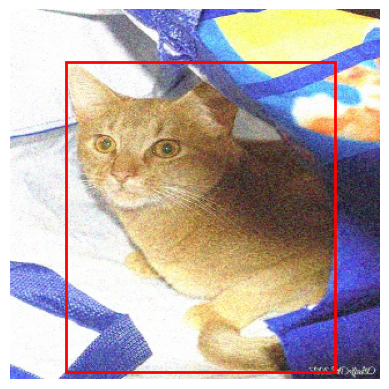

In [42]:
# plot the image and the bounding boxes
import matplotlib.pyplot as plt

plt.imshow(img)
for box in target["boxes"]:
    x1, y1, x2, y2 = box
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2))
plt.axis('off')

In [85]:
# geneate random tensor between 0 and 1
a = torch.rand(5)
a

tensor([0.4801, 0.1160, 0.6582, 0.0572, 0.7597])

In [86]:
a.to(torch.float8_e4m3fn)

tensor([0.4688, 0.1172, 0.6875, 0.0586, 0.7500], dtype=torch.float8_e4m3fn)

In [87]:
a.to(torch.float8_e4m3fnuz)

tensor([0.4688, 0.1172, 0.6875, 0.0586, 0.7500], dtype=torch.float8_e4m3fnuz)

In [88]:
a.to(torch.float8_e5m2)

tensor([0.5000, 0.1094, 0.6250, 0.0547, 0.7500], dtype=torch.float8_e5m2)

In [89]:
a.to(torch.float8_e5m2fnuz)

tensor([0.5000, 0.1094, 0.6250, 0.0547, 0.7500], dtype=torch.float8_e5m2fnuz)

In [122]:
valid_labels > 0

array([ True,  True,  True,  True])

In [ ]:
class CachedSSDLITEOBJDET_DATASET(Dataset):
    def __init__(self, dataset_class :SSDLITEOBJDET_DATASET, 
                root_dir: str, 
                split: str, 
                num_classes: int, 
                img_size: int=320, 
                dtype: torch.dtype=torch.float32, 
                mode: str="train",
                lmdb_path: str = None,
                map_size: int=1099511627776) -> None:
        super().__init__()
        self.root_dir, self.split, self.img_size, self.num_classes = root_dir, split.lower(), img_size, num_classes
        self.mode, self.dtype = mode.lower(), dtype
        self.dataset_class = dataset_class
        self.map_size = map_size
        self.lmdb_path = lmdb_path if lmdb_path else os.path.join(self.root_dir, f"{self.split}_cache")
        
        # preprocess the dataset and cache it in lmdb
        self.preprocess_dataset()
        
        self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False)
        with self.env.begin() as txn:
            self.length = txn.stat()['entries']

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with self.env.begin() as txn:
            data = msgpack.unpackb(txn.get(str(idx).encode()))
        img = torch.frombuffer(data[0], dtype=self.dtype).view(3, self.img_size, self.img_size) # channnels = 3 because of RGB
        boxes = torch.frombuffer(data[1], dtype=self.dtype).view(-1, 4)
        labels = torch.frombuffer(data[2], dtype=torch.uint8).view(-1)
        return img, {'boxes': boxes, 'labels': labels}

            # data = txn.get(str(idx).encode())
        # return pickle.loads(data)
    
    def preprocess_dataset(self) -> None:
        dataset = self.dataset_class(self.root_dir, self.split, self.num_classes, self.img_size, self.dtype, self.mode)
        env = lmdb.open(self.lmdb_path, map_size=self.map_size)  # 1TB
        
        with env.begin(write=True) as txn:
            for idx in tqdm(range(len(dataset))):
                image, target = dataset[idx]
                # Serialize and store
                # txn.put(
                #     str(idx).encode(),
                #     pickle.dumps((image, target))
                # )
                # serialize with msgpack (faster than pickle)
                txn.put(str(idx).encode(), msgpack.packb((
                image.numpy().tobytes(),
                target['boxes'].numpy().tobytes(),
                target['labels'].numpy().tobytes()
            )))
        shutil.rmtree(os.path.join(self.root_dir, self.split))
        del dataset

In [ ]:
from concurrent.futures import ThreadPoolExecutor

class AsyncPrefetcher:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.pool = ThreadPoolExecutor(max_workers=4)
        self.futures = []
        
    def __iter__(self):
        # Prefetch next 4 batches
        for _ in range(4):
            self.futures.append(self.pool.submit(next, self.dataloader))
        while True:
            yield self.futures.pop(0).result()
            self.futures.append(self.pool.submit(next, self.dataloader))

2

# Bypass CPU copy using NVIDIA Magnum IO
torch.utils.data.DataLoader(..., direct_io=True)

# Mount filesystem with GPU Direct support
mount -t gpfs /dev/nvme0n1 /datasets

# fused batch collation
@torch.jit.script
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return torch.stack(images, dim=0, memory_format=torch.channels_last), targets

1. dataloader configuration
2. parallelize label parsing
3. use nvidia dali for gpu based dataloading
4. use concurrent features in preprocess dataset to speed up the process

In [92]:
val_dataset = CachedSSDLITEOBJDET_DATASET(SSDLITEOBJDET_DATASET,
                                        DATASET_FOLDER_PATH,
                                        "val", 
                                        MODEL_NUM_CLASSES)

Number of items in the dataset: 2390


100%|██████████| 2390/2390 [00:30<00:00, 79.13it/s] 


In [18]:
import os
import time

class SSD_MOBILENET_V3_Large(nn.Module):
    def __init__(self, num_classes_with_bg:int) -> None:
        super(SSD_MOBILENET_V3_Large, self).__init__()
        self.num_classes_with_bg = num_classes_with_bg
        self.model = ssdlite320_mobilenet_v3_large(weights='COCO_V1', weights_backbone="DEFAULT") 
        self.model.head.classification_head = SSDLiteClassificationHead(
            in_channels=det_utils.retrieve_out_channels(self.model.backbone, (320, 320)),
            num_anchors=self.model.anchor_generator.num_anchors_per_location(),
            num_classes=self.num_classes_with_bg,
            norm_layer=partial(nn.BatchNorm2d, eps=0.001, momentum=0.03)
        )
        self.model.detections_per_img = 100
    
    def configure_optimizers(self, lr: float = 0.0001, betas: Tuple[float, float] = (0.9, 0.999), weight_decay: float = 0.0001, eps: float = 1e-08, fused: bool = True) -> torch.optim.Optimizer:        
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for _, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for _, p in param_dict.items() if p.dim() < 2]

        # Create AdamW optimizer and use the fused version if available 
        return torch.optim.AdamW([{'params': decay_params, 'weight_decay': weight_decay},
                                    {'params': nodecay_params, 'weight_decay': 0.0}], 
                                    lr=lr, 
                                    betas=betas, 
                                    eps=eps, 
                                    fused=fused)
    
    def forward(self, images: torch.Tensor, targets: dict=None):
        return self.model(images, targets)
    
    def load(self, checkpoint_path: dict, key_name: str = "model_state_dict", map_location: str = "cpu"):
        self.load_state_dict(torch.load(checkpoint_path, map_location=map_location)[key_name])
    
    def evaluate(self, dataset_root: str, device: torch.device|str, batch_size: int = 64):
        num_cores = os.cpu_count()
        print(f"Number of CPU cores: {num_cores}")
        
        metric = MeanAveragePrecision(
        iou_type="bbox",
        class_metrics=True,
        extended_summary=True)
        
        train_dataset = SSDLITEOBJDET_DATASET(dataset_root, split='train')
        val_dataset = SSDLITEOBJDET_DATASET(dataset_root, split='val')
        test_dataset = SSDLITEOBJDET_DATASET(dataset_root, split='test')
        
        # if device is a string
        if isinstance(device, str):
            device = device
        else:
            device = f"{device.type}:{device.index}"
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_cores, pin_memory=True, pin_memory_device=device)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_cores, pin_memory=True, pin_memory_device=device)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_cores, pin_memory=True, pin_memory_device=device)
        
        # splits = ['train', 'val', 'test']
        # loaders = [train_loader, val_loader, test_loader]
        splits = ['val', 'test']
        loaders = [val_loader, test_loader]
        results = {}
        for split, loader in zip(splits, loaders):
            print(f"Evaluating {split} set")
            self.eval()
            metric.reset()
            progress_bar = tqdm(loader, desc=f"Evaluating {split} set", unit="batch")
            with torch.no_grad():
                for images, targets in progress_bar:
                    images = list(image.to(device) for image in images)
                    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                    outputs = self(images)
                    metric.update(outputs, targets)
                results[split] =  metric.compute()
        return results
        

In [19]:
model = SSD_MOBILENET_V3_Large(num_classes_with_bg=MODEL_NUM_CLASSES)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load("ssd_checkpoint/checkpoint_1.pth")
model.to(device)

SSD_MOBILENET_V3_Large(
  (model): SSD(
    (backbone): SSDLiteFeatureExtractorMobileNet(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (2): Hardswish()
          )
          (1): InvertedResidual(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
                (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
              )
              (1): Conv2dNormActivation(
                (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_runn

In [20]:
results = model.evaluate(DATASET_FOLDER_PATH, device)

Number of CPU cores: 4
Evaluating val set


Evaluating val set: 100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Evaluating test set


Evaluating test set: 100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


In [ ]:
def train():
    # Set device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    # Load the model
    model = SSD_MOBILENET_V3_Large(num_classes_with_bg=MODEL_NUM_CLASSES)
    model.to(device)
    
    train_dataset = SSDLITEOBJDET_DATASET(DATASET_FOLDER_PATH, 'train')
    val_dataset = SSDLITEOBJDET_DATASET(DATASET_FOLDER_PATH, 'val')

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=num_cores, pin_memory=True, pin_memory_device="cuda:0")
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=num_cores, pin_memory=True, pin_memory_device="cuda:0")

    # Optimizer and scheduler
    optimizer = model.configure_optimizers(lr=0.0001, betas=(0.9, 0.999), weight_decay=0.001, eps=1e-08, fused=True)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        num_batches = len(train_loader)
        
        # Import tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for _, (images, targets) in enumerate(train_bar):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            batch_loss = losses.detach().item()
            total_loss += batch_loss
            
            # Update progress bar with current batch loss
            train_bar.set_postfix(loss=batch_loss)

        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}/{num_epochs} | Avg Train Loss: {avg_loss:.4f}")

        lr_scheduler.step()

        # Validation
        model.eval()
        metric = MeanAveragePrecision()
        with torch.no_grad():
            for images, targets in val_loader:
                images = list(img.to(device) for img in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                predictions = model(images)
                metric.update(predictions, targets)
        
        map_result = metric.compute()
        print(f"Epoch {epoch+1} | Val mAP: {map_result['map']:.4f}")

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, 'ssd_mobilenet_v3_finetuned.pth')

In [ ]:
# Run the training function
# train()

In [ ]:

        elapsed = time.time() - start_time
        
        results.append({
            'split': split,
            **split_metrics,
            'time': f"{elapsed:.1f}s"
        })
        
        print(f"\nCompleted {split} split in {elapsed:.1f} seconds")
        print(f"Split Metrics - mAP: {split_metrics['mAP']:.4f}, Precision: {split_metrics['Precision']:.4f}")

    # Create DataFrame
    df = pd.DataFrame(results).set_index('split')
    numeric_cols = ['mAP', 'mAP_50', 'mAP_75', 'mAP_small', 'mAP_medium', 
                   'mAP_large', 'Recall', 'Precision', 'F1']
    df[numeric_cols] = df[numeric_cols].applymap(lambda x: f"{float(x):.4f}")
    
    return df

def evaluate_split(model, dataloader, device, metric):
    """Evaluate with batch-level progress"""
    model.eval()
    metric.reset()
    
    # Batch progress bar
    batch_progress = tqdm(dataloader, 
                        desc="Processing batches",
                        leave=False,
                        position=1)
    
    with torch.no_grad():
        for images, targets in batch_progress:
            # Move data to device
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Inference
            predictions = model(images)
            metric.update(predictions, targets)
            
            # Update progress description
            batch_progress.set_postfix({
                'current_mAP': f"{metric.compute()['map'].item():.3f}",
                'batch_size': len(images)
            })

    # Final metrics
    metrics = metric.compute()
    
    return {
        'mAP': metrics['map'].item(),
        'mAP_50': metrics['map_50'].item(),
        'mAP_75': metrics['map_75'].item(),
        'mAP_small': metrics['map_small'].item(),
        'mAP_medium': metrics['map_medium'].item(),
        'mAP_large': metrics['map_large'].item(),
        'Recall': metrics['mar_100'].item(),
        'Class_APs': metrics['classes'].cpu().numpy().round(4),
        'Precision': metrics['precision'].cpu().numpy().mean().round(4),
        'Recall': metrics['recall'].cpu().numpy().mean().round(4),
        'F1': (2 * (metrics['precision'] * metrics['recall']) / 
              (metrics['precision'] + metrics['recall'] + 1e-16)).cpu().numpy().mean().round(4)
    }

def evaluate():
    print("\n🚀 Starting Comprehensive Evaluation")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"🔧 Using device: {device}")
    
    # Model loading
    print("\n🔄 Loading model weights...")
    start_load = time.time()
    model = SSD_MOBILENET_V3_Large(num_classes_with_bg=MODEL_NUM_CLASSES)

    print(f"✅ Model loaded in {time.time()-start_load:.1f}s")
    
    # Evaluation
    print("\n📊 Starting evaluation on all splits...")
    metrics_df = evaluate_model(model, DATASET_FOLDER_PATH, device)
    
    # Results display
    print("\n🎯 Final Metrics Summary:")
    print(metrics_df[['mAP', 'mAP_50', 'mAP_75', 'Recall', 'Precision', 'F1', 'time']])
    
    print("\n📈 Class-wise Performance:")
    class_df = pd.DataFrame(metrics_df['Class_APs'].tolist(), 
                          index=metrics_df.index).T
    class_df.columns = metrics_df.index
    print(class_df.round(4))
    
    print("\n🏁 Evaluation complete!")

if __name__ == '__main__':
    evaluate()